# Problem description

In this research, we will build neural networks using the Torch library to tackle a few classification problems:

In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random

sns.set(style="darkgrid", font_scale=1.4)

In [ ]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [ ]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

# Part 1. Moons dataset

In [ ]:
# Generating data
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

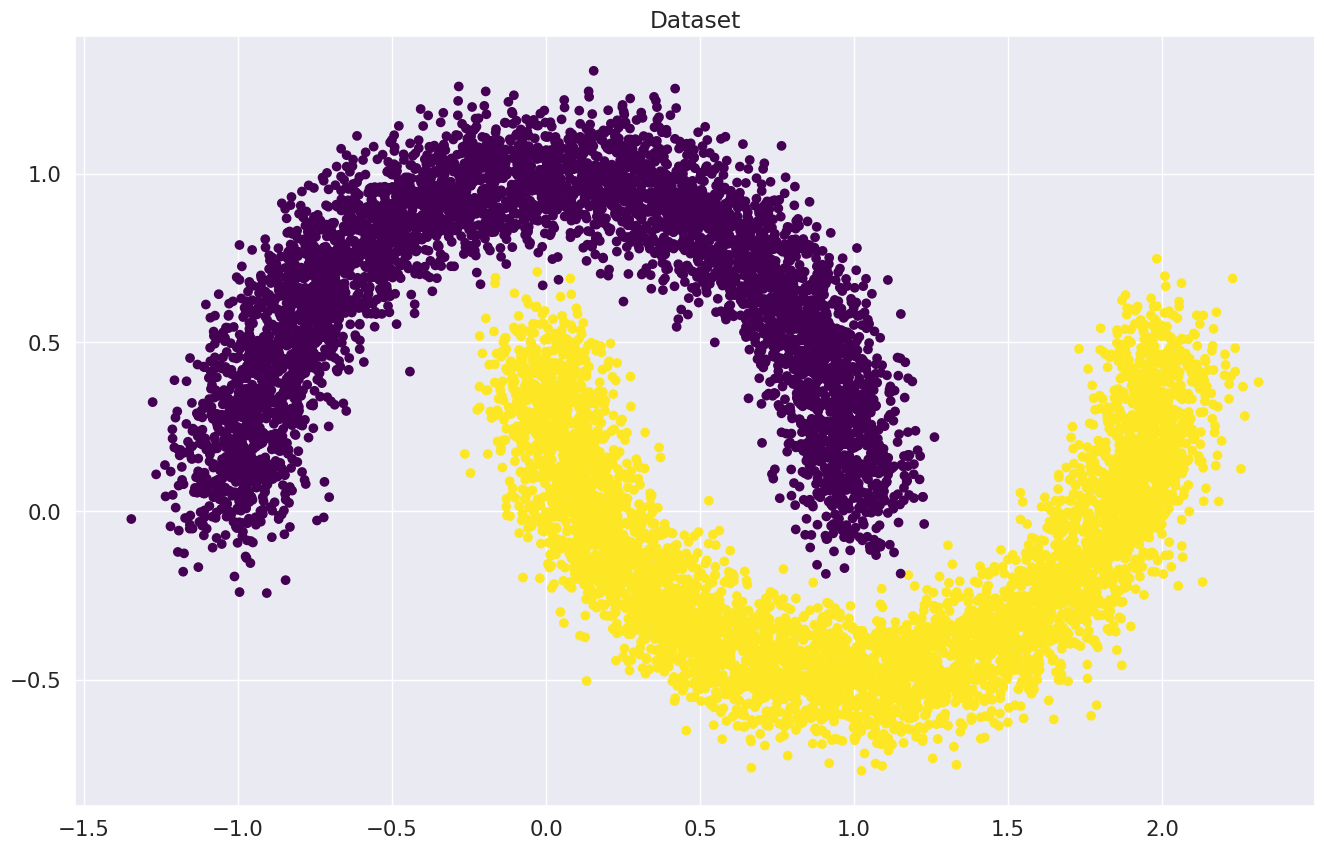

In [ ]:
# Visualising data
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Let's make a train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Data loading

In [ ]:
# Creating tensors with training and test data
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

Creating `Dataset` and `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

### Implementation of Logistic regression

We will create a module in PyTorch that implements $logits = XW + b$, where $W$ and $b$ are the parameters (`nn.Parameter`) of the model and initialize the weights with a normal distribution (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))
        else:
            self.register_parameter('bias_term', None)

    def forward(self, x):
        x =  torch.matmul(x, self.weights.t())
        if self.bias:
            x += self.bias
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

### Train loop

Let's go directly to the training.

Here's a pseudocode to help you figure out what's going on during training.

```python
for epoch in range(max_epochs):  # <----------- iterate through the dataset multiple times
    for x_batch, y_batch in dataset:  # <------ iterate through the dataset. Since we use SGD (not GD), we take batches of specified size
        optimizer.zero_grad()  # <------------- reset model gradients
        outp = model(x_batch)  # <------------- get "logits" from the model
        loss = loss_func(outp, y_batch)  # <--- calculate the loss for logistic regression
        loss.backward()  # <------------------- compute gradients
        optimizer.step()  # <------------------ perform gradient descent step
        if convergence:  # <------------------- break loop if convergence is reached
            break
```

### Implementation of the train loop

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.squeeze(1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  F.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.6796875
Iteration: 200
Batch accuracy: 0.84375
Iteration: 300
Batch accuracy: 0.890625
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.9140625
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.84375
Iteration: 800
Batch accuracy: 0.875

Iteration: 873.Convergence. Stopping iterations.


### Visualization of the results

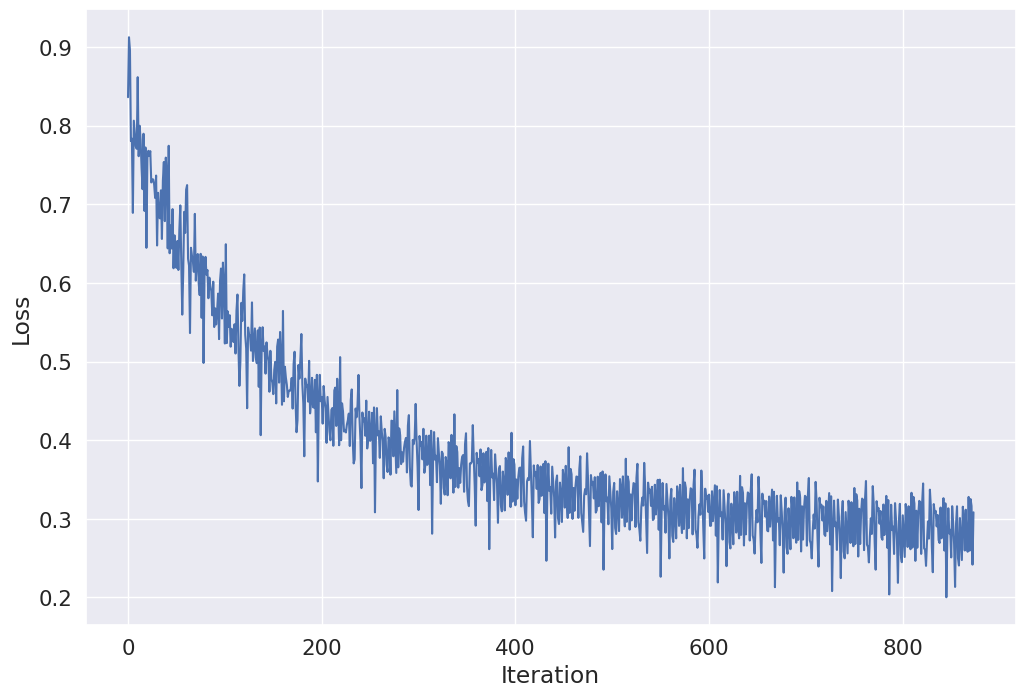

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

As we can see from the graph, the loss function is constantly and significantly going down, letting us to imply that the training is working and the network learns to predict more accurate.

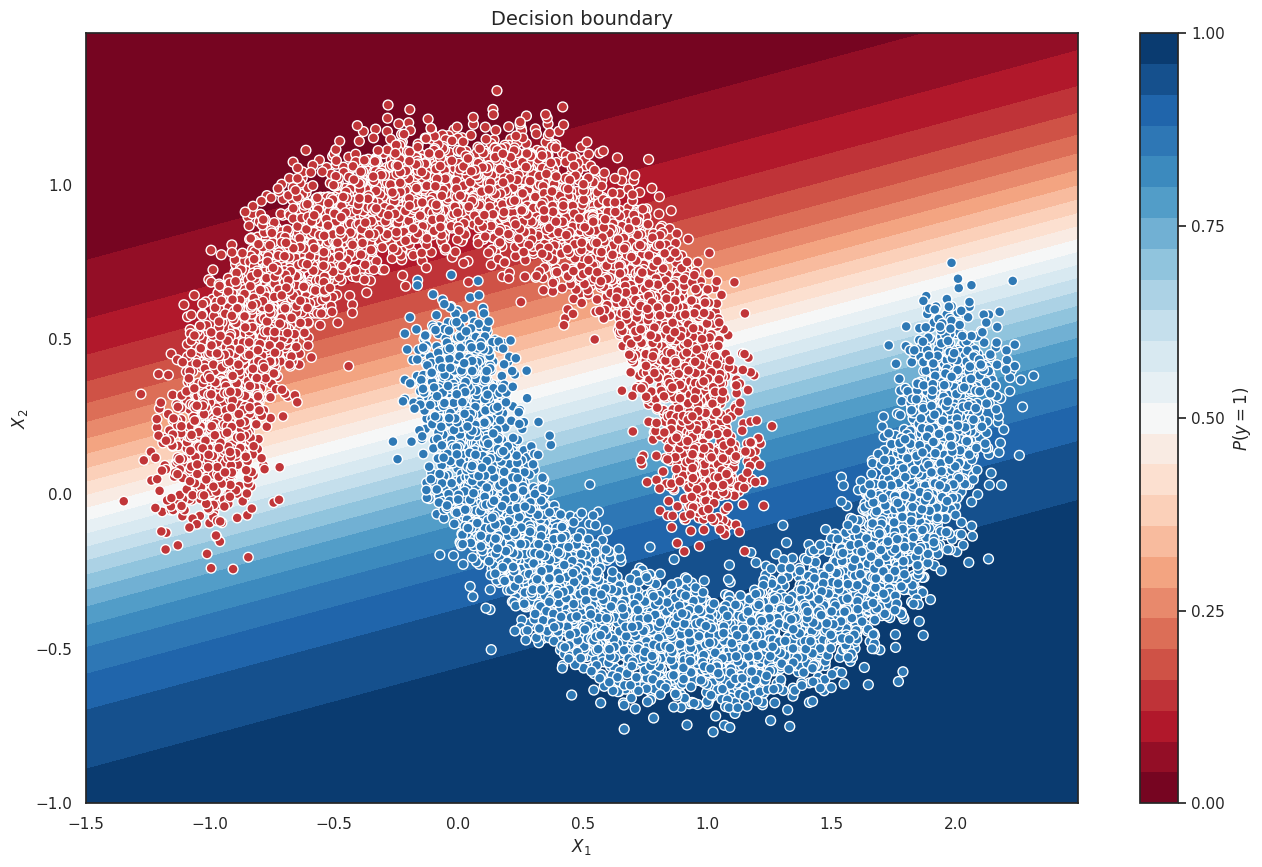

In [ ]:
# another visualisation of our results, now as clusters

import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Implementation of predict

In [ ]:
# here we test our neural network to evaluate its performance on given data
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        preds = outp.squeeze()
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten() > 0.5

### Accuracy on test.

In [ ]:
# final test accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_val, predict(val_dataloader, linear_regression))

0.8928

Sufficient!

# Part 2. MNIST dataset

Famous MNIST dataset with handwritten numbers

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(val_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 50.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.40MB/s]


## Part 2.1. Fully Connected Neural Networks (FCNN)
First, we will solve MNIST using a fully connected neural network.

### Simple FCNN

FCNN using Sequential.
The architecture is:
* Flattening a matrix into a vector (nn.Flatten);
* Two hidden layers of 128 nn-activated neurons.ELU;
* An output layer with 10 neurons.

In [ ]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=128),
    activation,
    nn.Linear(in_features=128, out_features=128),
    activation,
    nn.Linear(in_features=128, out_features=10)
)

Defining the loss function:

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)
Pseudocode:

```python
for epoch in range(max_epochs):  # <--------------- iterate through the dataset multiple times
    for k, dataloader in loaders.items():  # <----- multiple dataloaders for train/valid/test
        for x_batch, y_batch in dataloader:  # <--- iterate through dataset. Using SGD (not GD) with batches of specified size
            if k == "train":
                model.train()  # <------------------ set model to training mode
                optimizer.zero_grad()  # <--------- reset model gradients
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <- calculate loss for logistic regression
                loss.backward()  # <--------------- compute gradients
                optimizer.step()  # <-------------- perform gradient descent step
            else:  # <----------------------------- test/eval mode
                model.eval()  # <------------------ set model to evaluation mode
                with torch.no_grad():  # <--------- disable gradient calculation
                    outp = model(x_batch)  # <----- get "logits" from the model
            count_metrics(outp, y_batch)  # <------ calculate metrics
```

### Real train loop

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                 model = model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.7558
Loader: valid. Accuracy: 0.849
Epoch: 2
Loader: train. Accuracy: 0.8823
Loader: valid. Accuracy: 0.8795
Epoch: 3
Loader: train. Accuracy: 0.8965
Loader: valid. Accuracy: 0.917
Epoch: 4
Loader: train. Accuracy: 0.9118
Loader: valid. Accuracy: 0.9278
Epoch: 5
Loader: train. Accuracy: 0.9237
Loader: valid. Accuracy: 0.9321
Epoch: 6
Loader: train. Accuracy: 0.9341
Loader: valid. Accuracy: 0.9436
Epoch: 7
Loader: train. Accuracy: 0.9427
Loader: valid. Accuracy: 0.9512
Epoch: 8
Loader: train. Accuracy: 0.9496
Loader: valid. Accuracy: 0.9589
Epoch: 9
Loader: train. Accuracy: 0.9578
Loader: valid. Accuracy: 0.962
Epoch: 10
Loader: train. Accuracy: 0.9652
Loader: valid. Accuracy: 0.9672


### Activation functions

Now, we're going to test various activation functions and choose the most suitable one for our problem:

In [ ]:
elu_accuracy = accuracy["valid"]

[0.849, 0.8795, 0.917, 0.9278, 0.9321, 0.9436, 0.9512, 0.9589, 0.962, 0.9672]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Let's make a universal testing function
def test_activation_function(activation):
    # Setting up the number of epochs and defining loaders
    max_epochs = 10
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    # Building the model using the following transitions
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
    )

    # Defining the loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    accuracy = {"train": [], "valid": []}

    # Actual training part
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            # Split data in batches to not load all the data at once
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all

            epoch_acc = epoch_correct / epoch_all

            # Retrieving the accuracy from the cicle
            accuracy[k].append(epoch_acc)

    return accuracy["valid"]

Evaluation of the accuracy improvement over different activation functions:

In [ ]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.849, 0.8795, 0.917, 0.9278, 0.9321, 0.9436, 0.9512, 0.9589, 0.962, 0.9672]

In [ ]:
plain_accuracy = test_activation_function(nn.Identity()) #There is no non-linearity
plain_accuracy

[0.8278,
 0.8717,
 0.8862,
 0.8865,
 0.8912,
 0.9079,
 0.9105,
 0.9082,
 0.9093,
 0.9151]

In [ ]:
relu_accuracy = test_activation_function(nn.ReLU())
relu_accuracy

[0.8447, 0.8807, 0.901, 0.9171, 0.926, 0.9278, 0.9365, 0.9449, 0.9511, 0.9577]

In [ ]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(0.01))
leaky_relu_accuracy

[0.8463, 0.8765, 0.9045, 0.923, 0.9252, 0.9318, 0.9425, 0.9496, 0.9555, 0.9548]

As we can see, Linear activation shows the results significantly lower than the non-linear options. It proves the necessity of non-linear transition at least at 1 layer

### Accuracy
Let's plot the accuracy/epoch graph for each activation function.

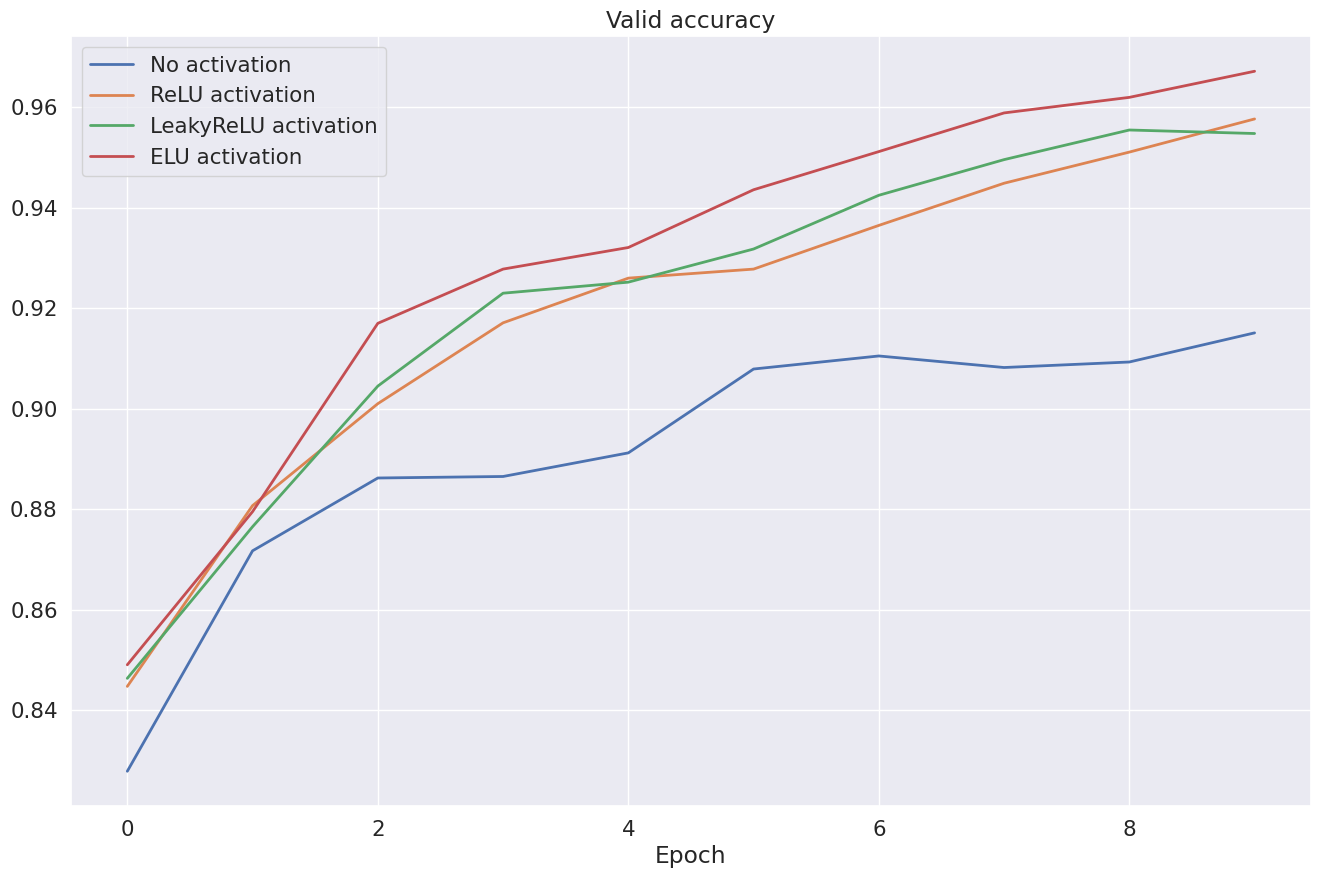

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

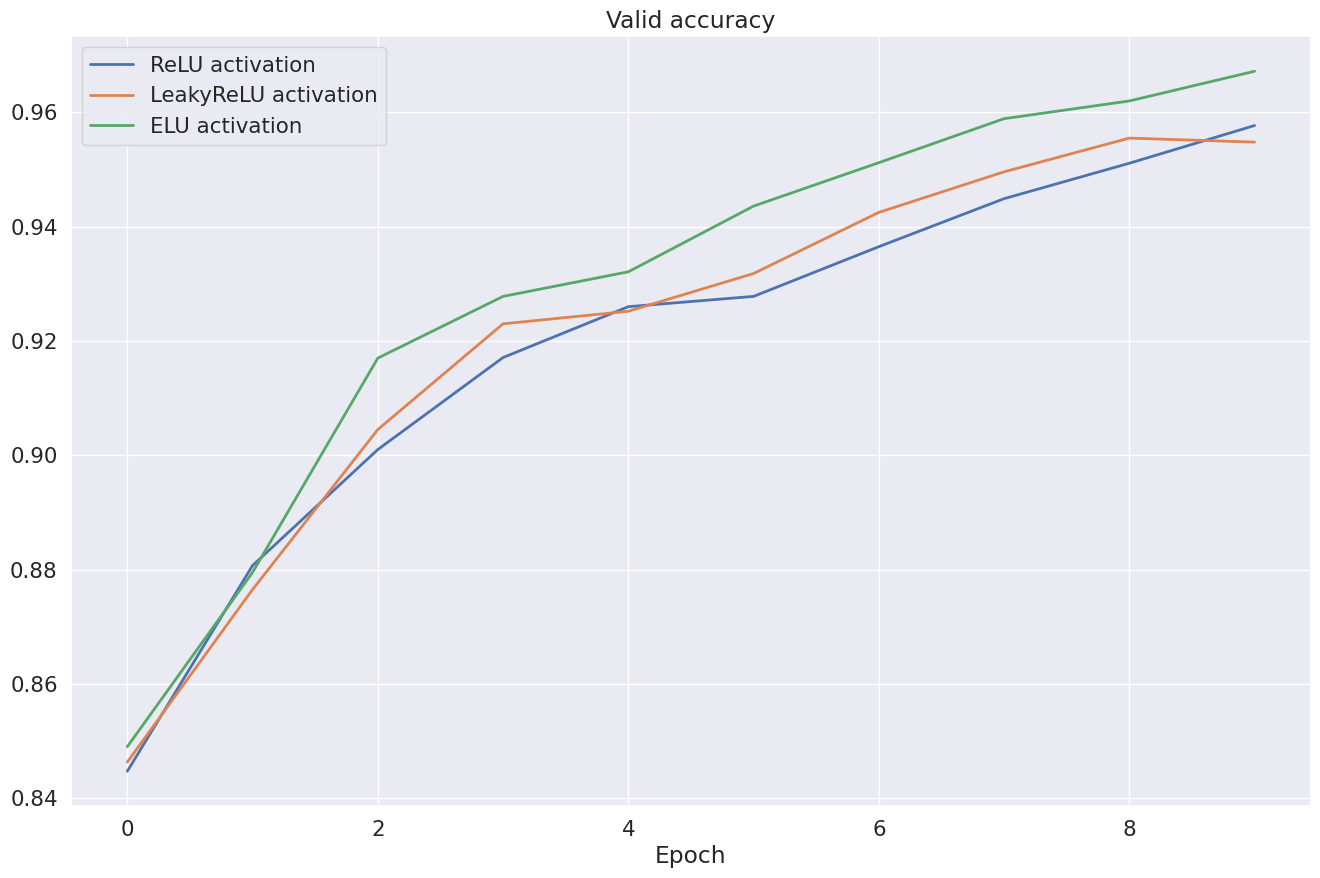

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

The best activation function is ELU with `0.9672` accuracy

## Part 2.2 Convolutional Neural Networks

### Implementation of LeNet (1998)

Architecture of our network:
* 3x3 convolutions (1 card at the input, 6 at the output) with ReLU activation;
* MaxPooling-a 2x2;
* 3x3 convolutions (6 cards at the input, 16 at the output) with ReLU activation;
* MaxPooling-a 2x2;
* Flattening (nn.Flatten);
* Fully connected layer with 120 neurons and ReLU activation;
* Fully connected layer with 84 neurons and ReLU activation;
* An output layer of 10 neurons.



In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # building the modules
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # setting up transitions
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# announcing our model
model = LeNet().to(device)

# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# defining the loaders
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### CNN training

In [ ]:
# almost the same training code as we've used before when were training the Sequential model
max_epochs = 10

accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

        epoch_acc = epoch_correct / epoch_all
        accuracy[k].append(epoch_acc)

In [ ]:
# retrieving the accuracy
lenet_accuracy = accuracy["valid"]
lenet_accuracy

[0.7982,
 0.8876,
 0.9327,
 0.9491,
 0.9559,
 0.9633,
 0.9732,
 0.9784,
 0.9838,
 0.9859]

Now let's test and evaluate the performance against various activation functions in `Sequential` networks:

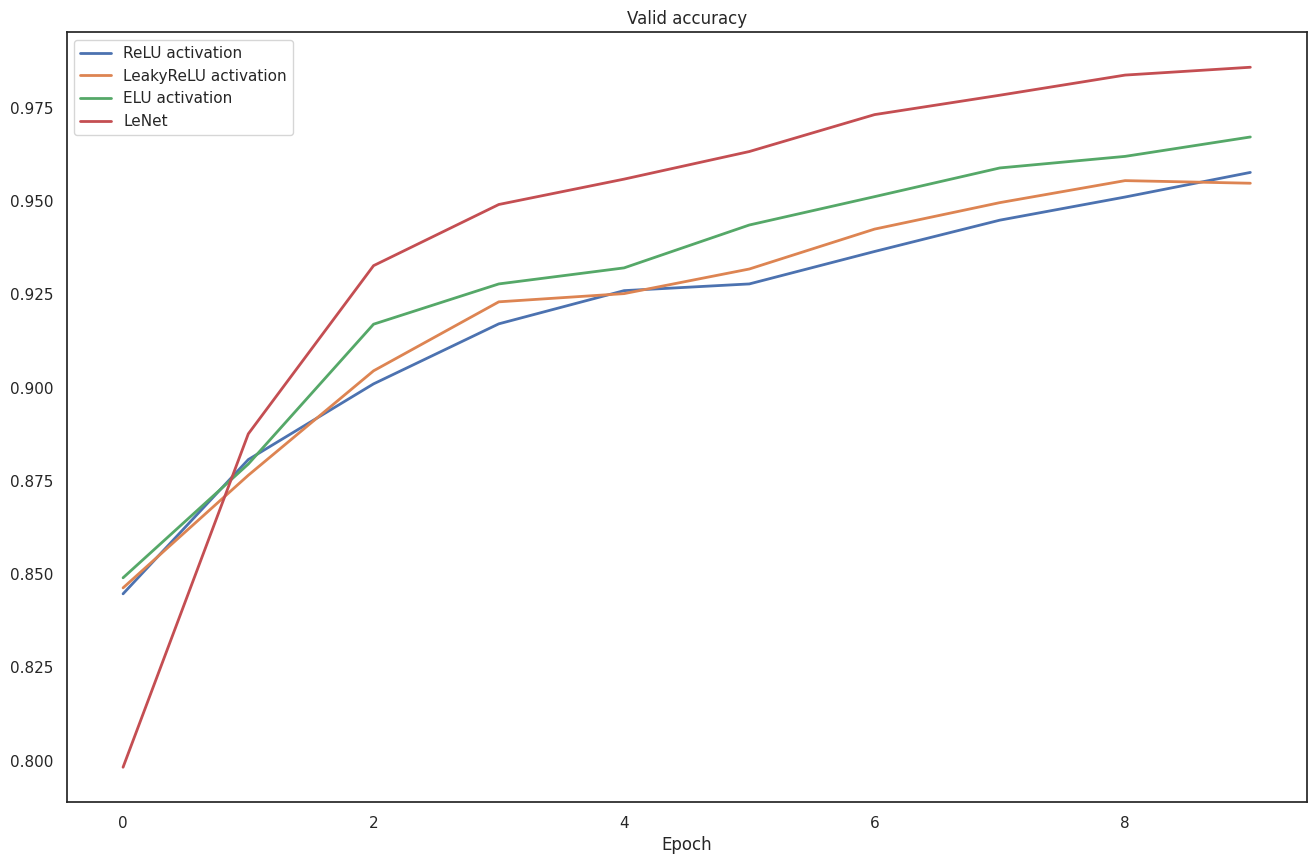

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Final `accuracy` of LeNet after training is `0.9859`, which is significantly higher than for previous  Sequential networks (Yann André Le Cun was an outstanding man!)